In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈
from dotenv import load_dotenv

load_dotenv()
base_dir = os.getenv('BASE_DIR')

In [2]:
folder_name = "landmarks_angle"

data = np.concatenate([
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/seq_npy_1722964119.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/seq_npy_flip_1722964155.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/seq_npy_flip_shift_1722964250.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/seq_npy_shift_1722964204.npy'))
], axis=0)

print(data.shape)
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(10992, 30, 235)


In [3]:
# 시퀀스의 마지막 요소 제외한 모든 값 가져와 할당
# 마지막 요소는 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)
print(np.unique(labels))  # 레이블 값 출력

(10992, 30, 234)
(10992,)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [4]:
from setting import actions
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape
# y_data 형태 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...]

(10992, 10)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float64)  # 입력 데이터
y_data = y_data.astype(np.float64)  # 레이블

# train data : validation data = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=2024)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

print(x_train.shape[1:3])

(8793, 30, 234) (8793, 10)
(2199, 30, 234) (2199, 10)
(30, 234)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(actions), activation='softmax'),
])

# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               185856    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 194762 (760.79 KB)
Trainable params: 194762 (760.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 훈련
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=20, verbose=1, mode='auto'),
        # early stopping 적용
        # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ]
)

Epoch 1/100


34/35 [============================>.] - ETA: 0s - loss: 1.9871 - acc: 0.2571
Epoch 1: val_acc improved from -inf to 0.45248, saving model to models\model.h5
35/35 [==============================] - 9s 153ms/step - loss: 1.9835 - acc: 0.2586 - val_loss: 1.5635 - val_acc: 0.4525 - lr: 0.0010
Epoch 2/100
 1/35 [..............................] - ETA: 3s - loss: 1.6162 - acc: 0.4180

c:\Users\mshof\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - ETA: 0s - loss: 1.4300 - acc: 0.4787
Epoch 2: val_acc improved from 0.45248 to 0.59118, saving model to models\model.h5
35/35 [==============================] - 6s 161ms/step - loss: 1.4300 - acc: 0.4787 - val_loss: 1.2075 - val_acc: 0.5912 - lr: 0.0010
Epoch 3/100
34/35 [============================>.] - ETA: 0s - loss: 1.1841 - acc: 0.5842
Epoch 3: val_acc improved from 0.59118 to 0.66803, saving model to models\model.h5
35/35 [==============================] - 5s 146ms/step - loss: 1.1829 - acc: 0.5842 - val_loss: 1.0064 - val_acc: 0.6680 - lr: 0.0010
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 0.8798 - acc: 0.6879
Epoch 4: val_acc improved from 0.66803 to 0.73352, saving model to models\model.h5
35/35 [==============================] - 5s 133ms/step - loss: 0.8798 - acc: 0.6879 - val_loss: 0.7439 - val_acc: 0.7335 - lr: 0.0010
Epoch 5/100
34/35 [============================>.] - ETA: 0s - loss: 0.7267 - acc: 0.7471
E

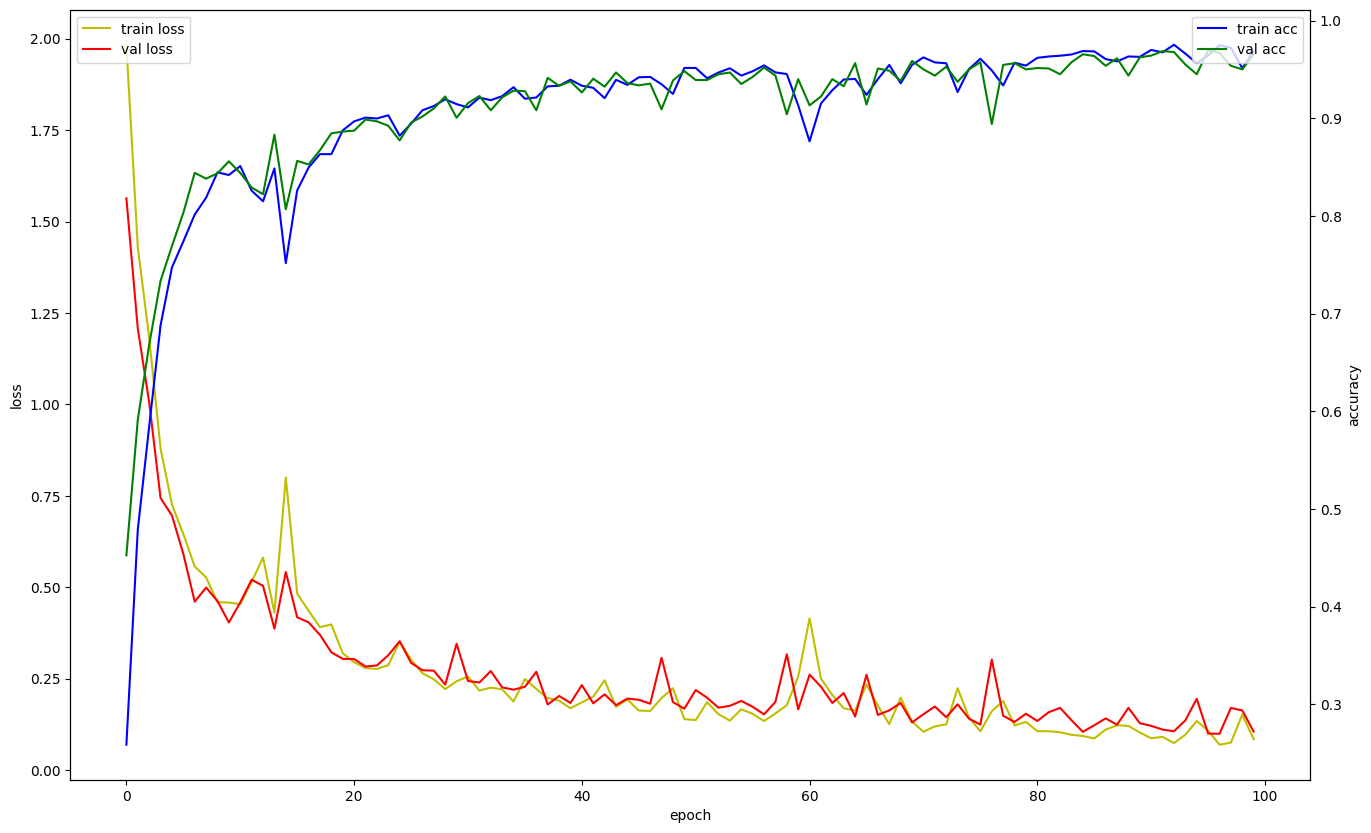

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()